In [1]:
# %% Import JAX and enable 64-bit precision
import jax
jax.config.update("jax_enable_x64", True)

In [12]:
import numpy as np
import re
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
import importlib

import timeit

In [20]:
%load_ext autoreload
%autoreload 2
importlib.reload(importlib.import_module('c1lgkt.jax.fields.equilibrium'))
importlib.reload(importlib.import_module('c1lgkt.jax.fields.geometry_handlers'))
from c1lgkt.jax.fields.equilibrium import Equilibrium
from c1lgkt.jax.fields.geometry_handlers import GeometryHandler, FieldlinePusher

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:

fieldline_pusher = FieldlinePusher()

In [22]:
times = range(2000, 2500, 10)

# Profiling
start_time = timeit.default_timer()

for time in times:
    filename = R"C:\Users\maple\OneDrive\Research\IFS\Scripts\gpr\eqs174864\g174864.0" + str(time)

    eq = Equilibrium.from_gfile(filename)
    geom = GeometryHandler(eq, fieldline_pusher)

    curr_time = timeit.default_timer()
    print(f"Time for {time}: {curr_time - start_time} seconds")
    start_time = curr_time

    #fieldline_pusher.compute_q_and_dtheta(eq, jnp.linspace(0.1, 0.5, 192))

Time for 2000: 6.115334000001894 seconds
Time for 2010: 5.620606399999815 seconds
Time for 2020: 0.43292509999810136 seconds
Time for 2030: 0.4604025000007823 seconds
Time for 2040: 6.034173399999418 seconds
Time for 2050: 0.4290078000012727 seconds
Time for 2060: 0.4359702000001562 seconds
Time for 2070: 0.44936819999929867 seconds
Time for 2080: 0.4944074000013643 seconds
Time for 2090: 0.44850489999953425 seconds
Time for 2100: 0.5338373000013235 seconds
Time for 2110: 0.4962655999988783 seconds
Time for 2120: 0.4521649999987858 seconds
Time for 2130: 0.4514817999988736 seconds
Time for 2140: 0.4551547000010032 seconds
Time for 2150: 0.46153530000083265 seconds
Time for 2160: 0.43183219999991707 seconds
Time for 2170: 0.447322100000747 seconds
Time for 2180: 0.4459915000006731 seconds
Time for 2190: 0.5184540999980527 seconds
Time for 2200: 6.185441300000093 seconds
Time for 2210: 6.237348999999085 seconds
Time for 2220: 6.390675500002544 seconds
Time for 2230: 0.5277026999974623 se

In [10]:
with open(filename, 'r') as f:
    data = f.readlines()

    # Start with the first line
    tokens = data[0].split()
    # Get the number of radial and vertical grid points
    Nr = int(tokens[-2])
    Nz = int(tokens[-1])
    Npsi  = Nr

    # Helper function to read a line of tokens
    def read_tokens(line: int):
        return list(map(float,re.findall(r'-?\d\.\d*[eE][-+]\d*', data[line])))

    # The second line contains information for constructing RZ grid
    rdim, zdim, rcentr, rmin, zmid = read_tokens(line=1)
    rmax = rmin + rdim
    zmin = zmid - zdim / 2
    zmax = zmid + zdim / 2

    rgrid = jnp.linspace(rmin, rmax, Nr)
    zgrid = jnp.linspace(zmin, zmax, Nz)

    # The third line contains R,Z of magnetic axis, psi at magnetic axis, and LCFS
    raxis, zaxis, psiaxis, psix, bcentr = tokens = read_tokens(line=2)

    # Out of convenience, renormalize psi such that psiaxis = 0
    psix -= psiaxis
    
    # read EFIT-calculated plasma current, psi at magnetic axis (duplicate),
    # dummy, R of magnetic axis (duplicate), dummy
    ip, _, _, _, _ = read_tokens(line=3)

    # Skip the 5th line
    _, _, _, _, _ = read_tokens(line=4)

    # Start keeping track of the current line
    line = 5

    # Helper function to read arrays
    def read_array(begin_read: int, npts: int):
        # Number of rows to read in an array
        nrows = npts//5
        if npts % 5 != 0:     # catch truncated rows
            nrows += 1

        temp_array = []
        for i in range(nrows):
            temp_array.extend(read_tokens(line=begin_read + i))
        return begin_read + nrows, jnp.array(temp_array)
    
    # First, read in ff
    line, ff = read_array(line, Npsi)
    # Next, read pressure
    line, fluxPres = read_array(line, Npsi)
    # Read ffprim
    line, ffprim = read_array(line, Npsi)
    # Read pprime
    line, pprime = read_array(line, Npsi)

    # psi grid on which the flux functions are defined
    psi = jnp.linspace(0, psix, Npsi)

    # Now, read the 2d psirz array
    line, psirz = read_array(line, Nr * Nz)
    psirz = psirz.reshape((Nz, Nr)) - psiaxis  # renormalize psirz

    # Now read q profile
    line, qpsi = read_array(line, Npsi)

    # Now, we read the LCFS and wall points
    tokens = data[line].split()
    Nlcfs = int(tokens[0])
    Nwall = int(tokens[1])
    line += 1

    line, lcfsrz = read_array(line, 2*Nlcfs)
    lcfsrz = lcfsrz.reshape((Nlcfs, 2)).T
    line, wallrz = read_array(line, 2*Nwall)
    wallrz = wallrz.reshape((Nwall, 2)).T

    # Estimate the X-point location from the LCFS points.
    # TODO: Need to do something about multiple X-points
    zmin_idx = jnp.argmin(lcfsrz[1,:])
    zx = lcfsrz[1, zmin_idx]
    rx = lcfsrz[0, zmin_idx]

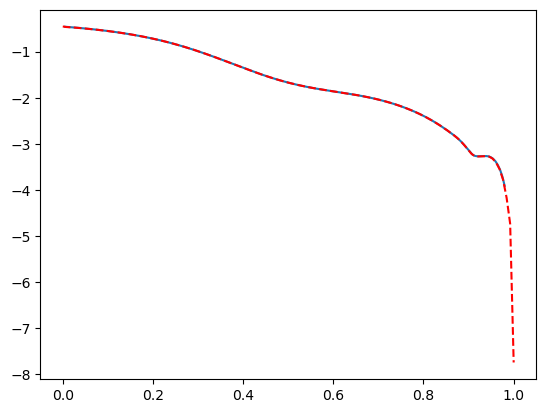

In [13]:
plt.figure()
plt.plot(geom.psi_surf/eq.psix, geom.q_surf)
plt.plot(psi/eq.psix, -qpsi, 'r--')

In [11]:
eq.psix

0.3333651646

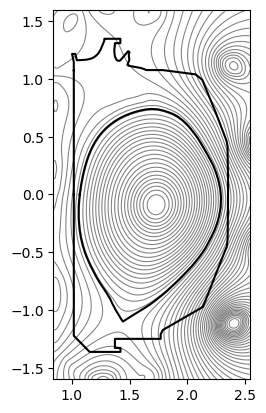

In [4]:
plt.figure()
ax = plt.subplot(111)
eq.plot_magnetic_geometry(ax)